## Goal: What are Fst scores per exon + ss (+-2bp)
For exons that are 
* unique to one population or the other
* shared between the population
* this is on the exon level~!

In [36]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot
import math


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [27]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [28]:
df = pd.read_csv(proc_cfg(config['lr']['exons_ss_in_pops_fsts_summary'], od),
                 sep='\t')
df.rename({'pop2_der':'pop2_det'}, 
          axis=1, inplace=True)

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))
df.head()

2943235
1719222


,eid,novelty,pop1_det,pop2_det,Chromosome,Strand,Start,End,pop1,pop2,End_b,fst,Start_b
197,chr1_+_100007033_100007156,Known,True,True,chr1,+,100007031,100007158,HAC,YRI,100007048,0.393014,100007047
198,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,YRI,100043099,0.041198,100043098
199,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,YRI,100043213,0.000000,100043212
200,chr1_+_100049908_100050004,Known,True,True,chr1,+,100049906,100050006,HAC,YRI,100049941,0.018298,100049940
201,chr1_+_100140407_100141019,Known,True,True,chr1,+,100140405,100141021,HAC,YRI,100140797,0.047965,100140796


In [29]:
df.to_csv('250212_snp_exon_intersect_fst.tsv', sep='\t')
df.head()

,eid,novelty,pop1_det,pop2_det,Chromosome,Strand,Start,End,pop1,pop2,End_b,fst,Start_b
197,chr1_+_100007033_100007156,Known,True,True,chr1,+,100007031,100007158,HAC,YRI,100007048,0.393014,100007047
198,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,YRI,100043099,0.041198,100043098
199,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,YRI,100043213,0.000000,100043212
200,chr1_+_100049908_100050004,Known,True,True,chr1,+,100049906,100050006,HAC,YRI,100049941,0.018298,100049940
201,chr1_+_100140407_100141019,Known,True,True,chr1,+,100140405,100141021,HAC,YRI,100140797,0.047965,100140796


In [16]:
gb_cols = ['eid', 'novelty', 'pop1_det', 'pop2_det',
            'pop1', 'pop2']
keep_cols = gb_cols+['fst']


# make sure there are no dupe eid + contrast + var. posiition
assert len(df[gb_cols+['End_b', 'Start_b']].drop_duplicates().index) == len(df.index) # oop there's a bug somewhere upstream w/ the vcf processing

print('REMOVE ME WHEN FABIEN FIXES FST STUFF')
print(len(df.index))
df = df.drop_duplicates(subset=gb_cols+['End_b', 'Start_b'], keep=False)
print(len(df.index))
df.head()

REMOVE ME WHEN FABIEN FIXES FST STUFF
1719222
1719222


,eid,novelty,pop1_det,pop2_det,Chromosome,Strand,Start,End,pop1,pop2,End_b,fst,Start_b
197,chr1_+_100007033_100007156,Known,True,True,chr1,+,100007031,100007158,HAC,YRI,100007048,0.393014,100007047
198,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,YRI,100043099,0.041198,100043098
199,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,YRI,100043213,0.000000,100043212
200,chr1_+_100049908_100050004,Known,True,True,chr1,+,100049906,100050006,HAC,YRI,100049941,0.018298,100049940
201,chr1_+_100140407_100141019,Known,True,True,chr1,+,100140405,100141021,HAC,YRI,100140797,0.047965,100140796


[Text(0.5, 15.0, 'Population 2'),
 Text(33.0, 0.5, 'Popluation 1'),
 Text(0.5, 1.0, 'Fsts of exonic, biallelic SNPs based on\n exon detection')]

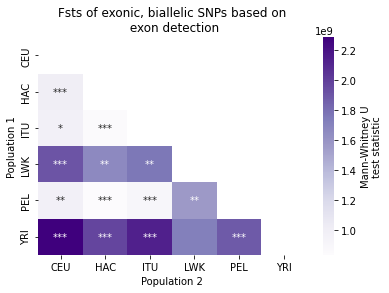

In [24]:
# loop through each contrast
stat_df = pd.DataFrame()
for pop1, pop2 in zip(df[['pop1', 'pop2']].drop_duplicates()['pop1'].tolist(),
                      df[['pop1', 'pop2']].drop_duplicates()['pop2'].tolist()):
    temp = df.loc[(df.pop1==pop1)&(df.pop2==pop2)]
    temp.rename({'pop1_det':pop1,
             'pop2_det':pop2}, axis=1, inplace=True)

    temp['med_per_group'] = temp.groupby([pop1, pop2])['fst'].transform('median')
    temp['mean_per_group'] = temp.groupby([pop1, pop2])['fst'].transform('mean')

    # print(temp[[pop1, pop2, 'med_per_group']].drop_duplicates())
    # print(temp[[pop1, pop2, 'mean_per_group']].drop_duplicates())

    temp['thing'] = ''
    temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing'] = f'{pop1}_{pop2}'
    temp.loc[(temp[pop1]==True)&(temp[pop2]==False), 'thing'] = f'{pop1}'
    temp.loc[(temp[pop1]==False)&(temp[pop2]==True), 'thing'] = f'{pop2}'     

    temp['thing2'] = 'unique'
    temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing2'] = 'shared'
    
    x = temp.loc[temp.thing2=='unique','fst'].tolist() # hyp. --> greater
    y = temp.loc[temp.thing2=='shared','fst'].tolist()
    
    # print(f'{pop1} vs {pop2}')
    # print(temp.loc[temp.thing2=='unique','fst'].median())
    # print(temp.loc[temp.thing2=='shared','fst'].median())
    # print()

    stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    temp3 = pd.DataFrame(data=[[pop1, pop2, stat, pval]], 
                         columns=['pop1', 'pop2', 'stat', 'pval'])
    stat_df = pd.concat([stat_df, temp3], axis=0)
    
    # add mirror as well 
    temp3 = pd.DataFrame(data=[[pop2, pop1, stat, pval]], 
                         columns=['pop1', 'pop2', 'stat', 'pval'])
    stat_df = pd.concat([stat_df, temp3], axis=0)

# fdr correction
from statsmodels.stats.multitest import multipletests
_, adj_p_vals, _, _ = multipletests(stat_df.pval.tolist(), method='fdr_bh')
stat_df['adj_pval'] = adj_p_vals
stat_df.head()

# add sig. annotation
# * <= 0.05
# ** <= 0.01
# *** <= 0.001
stat_df['sig_annot'] = ''
# stat_df.loc[stat_df.pval <= 0.05, 'sig_annot'] = '*'
# stat_df.loc[stat_df.pval <= 0.01, 'sig_annot'] = '**'
# stat_df.loc[stat_df.pval <= 0.001, 'sig_annot'] = '***'
stat_df.loc[stat_df.adj_pval <= 0.05, 'sig_annot'] = '*'
stat_df.loc[stat_df.adj_pval <= 0.01, 'sig_annot'] = '**'
stat_df.loc[stat_df.adj_pval <= 0.001, 'sig_annot'] = '***'

# pivot x2 to get a stat and annot df to plot
stat_df1 = stat_df.pivot(index='pop1', columns='pop2', values='stat')
annot_df = stat_df.pivot(index='pop1', columns='pop2', values='sig_annot')


# apply upper mask to both
# Mask the upper triangle
mask = np.triu(stat_df1)

ax = sns.heatmap(stat_df1, cmap='Purples',
            annot=annot_df,
            fmt='',
            mask=mask, 
            cbar_kws={'label': 'Mann-Whitney U\ntest statistic'})

# labels need them
ax.set(xlabel='Population 2',
       ylabel='Popluation 1',
       title='Fsts of exonic, biallelic SNPs based on\n exon detection')

In [30]:
df.head()

,eid,novelty,pop1_det,pop2_det,Chromosome,Strand,Start,End,pop1,pop2,End_b,fst,Start_b
197,chr1_+_100007033_100007156,Known,True,True,chr1,+,100007031,100007158,HAC,YRI,100007048,0.393014,100007047
198,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,YRI,100043099,0.041198,100043098
199,chr1_+_100043072_100043229,Known,True,True,chr1,+,100043070,100043231,HAC,YRI,100043213,0.000000,100043212
200,chr1_+_100049908_100050004,Known,True,True,chr1,+,100049906,100050006,HAC,YRI,100049941,0.018298,100049940
201,chr1_+_100140407_100141019,Known,True,True,chr1,+,100140405,100141021,HAC,YRI,100140797,0.047965,100140796


## Are differences more pronounced when we look at novel exons vs. known exons? 

In [37]:
big_stat_df = pd.DataFrame()
for nov in df.novelty.unique():
    # loop through each contrast
    stat_df = pd.DataFrame()
    for pop1, pop2 in zip(df[['pop1', 'pop2']].drop_duplicates()['pop1'].tolist(),
                          df[['pop1', 'pop2']].drop_duplicates()['pop2'].tolist()):
        temp = df.loc[(df.pop1==pop1)&(df.pop2==pop2)&(df.novelty==nov)]
        temp.rename({'pop1_det':pop1,
                 'pop2_det':pop2}, axis=1, inplace=True)

        temp['med_per_group'] = temp.groupby([pop1, pop2])['fst'].transform('median')
        temp['mean_per_group'] = temp.groupby([pop1, pop2])['fst'].transform('mean')

        # print(temp[[pop1, pop2, 'med_per_group']].drop_duplicates())
        # print(temp[[pop1, pop2, 'mean_per_group']].drop_duplicates())

        temp['thing'] = ''
        temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing'] = f'{pop1}_{pop2}'
        temp.loc[(temp[pop1]==True)&(temp[pop2]==False), 'thing'] = f'{pop1}'
        temp.loc[(temp[pop1]==False)&(temp[pop2]==True), 'thing'] = f'{pop2}'     

        temp['thing2'] = 'unique'
        temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing2'] = 'shared'

        x = temp.loc[temp.thing2=='unique','fst'].tolist() # hyp. --> greater
        y = temp.loc[temp.thing2=='shared','fst'].tolist()

        # print(f'{pop1} vs {pop2}')
        # print(temp.loc[temp.thing2=='unique','fst'].median())
        # print(temp.loc[temp.thing2=='shared','fst'].median())
        # print()

        stat, pval = st.mannwhitneyu(x, y, alternative='greater')
        temp3 = pd.DataFrame(data=[[pop1, pop2, stat, pval, nov]], 
                             columns=['pop1', 'pop2', 'stat', 'pval', 'novelty'])
        stat_df = pd.concat([stat_df, temp3], axis=0)
        big_stat_df = pd.concat([big_stat_df, temp3], axis=0)
        

        # add mirror as well 
        temp3 = pd.DataFrame(data=[[pop2, pop1, stat, pval, nov]], 
                             columns=['pop1', 'pop2', 'stat', 'pval', 'novelty'])
        stat_df = pd.concat([stat_df, temp3], axis=0)
        big_stat_df = pd.concat([big_stat_df, temp3], axis=0)

    # fdr correction
    from statsmodels.stats.multitest import multipletests
    _, adj_p_vals, _, _ = multipletests(stat_df.pval.tolist(), method='fdr_bh')
    stat_df['adj_pval'] = adj_p_vals
    stat_df['-log10(adj_pval)'] = -1*np.log10(stat_df.adj_pval.tolist())
    
    # add sig. annotation
    # * <= 0.05
    # ** <= 0.01
    # *** <= 0.001
    stat_df['sig_annot'] = ''
    # stat_df.loc[stat_df.pval <= 0.05, 'sig_annot'] = '*'
    # stat_df.loc[stat_df.pval <= 0.01, 'sig_annot'] = '**'
    # stat_df.loc[stat_df.pval <= 0.001, 'sig_annot'] = '***'
    stat_df.loc[stat_df.adj_pval <= 0.05, 'sig_annot'] = '*'
    stat_df.loc[stat_df.adj_pval <= 0.01, 'sig_annot'] = '**'
    stat_df.loc[stat_df.adj_pval <= 0.001, 'sig_annot'] = '***'

    # plotting heatmap w/ test statistic
    # pivot x2 to get a stat and annot df to plot
    stat_df1 = stat_df.pivot(index='pop1', columns='pop2', values='stat')
    annot_df = stat_df.pivot(index='pop1', columns='pop2', values='sig_annot')


    # apply upper mask to both
    # Mask the upper triangle
    mask = np.triu(stat_df1)

    ax = sns.heatmap(stat_df1, cmap='Purples',
                annot=annot_df,
                fmt='',
                mask=mask, 
                cbar_kws={'label': 'Mann-Whitney U\ntest statistic'})

    # labels need them
    ax.set(xlabel='Population 2',
           ylabel='Population 1',
           title=f'Fsts of exonic, biallelic SNPs based on\n {nov} exon detection')
    plt.show()
    plt.clf()
    
    # plotting heatmap w/ adj. pval 
    # pivot x2 to get a stat and annot df to plot
    stat_df1 = stat_df.pivot(index='pop1', columns='pop2', values='-log10(adj_pval)')
    annot_df = stat_df.pivot(index='pop1', columns='pop2', values='sig_annot')


    # apply upper mask to both
    # Mask the upper triangle
    mask = np.triu(stat_df1)

    ax = sns.heatmap(stat_df1, cmap='Purples',
                annot=annot_df,
                fmt='',
                mask=mask, 
                cbar_kws={'label': '-log10(Adj. p-val)'})

    # labels need them
    ax.set(xlabel='Population 2',
           ylabel='Population 1',
           title=f'Fsts of exonic, biallelic SNPs based on\n {nov} exon detection')
    plt.show()
    plt.clf()

TypeError: cannot convert the series to <class 'float'>

In [42]:
np.log10(stat_df.adj_pval.tolist())

array([-2.55642120e+00, -2.55642120e+00, -1.39890983e+00, -1.39890983e+00,
       -2.49672044e+00, -2.49672044e+00, -6.39327602e+00, -6.39327602e+00,
       -6.51186075e+00, -6.51186075e+00, -2.01752918e+00, -2.01752918e+00,
       -2.61729807e-03, -2.61729807e-03, -2.96243470e+00, -2.96243470e+00,
       -2.23200299e+00, -2.23200299e+00, -2.23200299e+00, -2.23200299e+00,
       -2.23200299e+00, -2.23200299e+00, -4.50463691e+00, -4.50463691e+00,
       -2.11752601e+00, -2.11752601e+00, -6.50231709e+00, -6.50231709e+00,
       -1.89338132e+00, -1.89338132e+00])